### CNN
### k-fold cross varidation

In [ ]:
#ライブラリのmountという関数を使って個人のGoogle Driveを'/content/drive'にマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
# cnn model
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from numpy import vstack
from pandas import read_csv
from matplotlib import pyplot
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import  KFold, StratifiedKFold
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imblearn.over_sampling import SMOTE

import pickle

In [ ]:
# params
test_size = 0.2
epochs=30
batch_size=16
lr=0.1
n_splits=5

In [ ]:
files = ["filename1", "filename2", "filename3",]
images = 259
frames = 550
channels = 6

In [ ]:
def load_group(filenames, dataset, prefix=''):
    loaded_EEG = list()
    loaded_label = list()
    for name in filenames:
        with open(f'{prefix}{name}_{dataset}.dat', mode='rb') as f:
          data_EEG = pickle.load(f)
          label = pickle.load(f)
          data_EEG = data_EEG.tolist()
          label = label.tolist()
          loaded_EEG.append(data_EEG)
          loaded_label.append(label)
    # stack group so that features are the 3rd dimension
    loaded_EEG = vstack(loaded_EEG)
    loaded_label = np.array(loaded_label)[:, :, 1].reshape(-1, 1)
    loaded_EEG = np.transpose(loaded_EEG, (0,2,1))

    return loaded_EEG, loaded_label

In [ ]:
def load_label(labelcategory, Y):
    if labelcategory == "labelA":
      # 1←好感度は高め
      # 2←不気味ではない
      # 3←HL90~100(不気味)
      # 4←HL100（人）
      Y = Y.astype(np.float16)
      for i in range(len(Y)):
        if Y[i] == 100:
          Y[i] = 4
        elif  (Y[i]<100) & (Y[i]>=90):
          Y[i] = 3
        elif  (Y[i]<90) & (Y[i]>=80):
            Y[i] = 2
        elif  (Y[i]<80) & (Y[i]>=70):
          Y[i] = 2
        elif  (Y[i]<70) & (Y[i]>=60):
            Y[i] = 2
        elif  (Y[i]<60) & (Y[i]>=50):
          Y[i] = 1
        elif  (Y[i]<50) & (Y[i]>=40):
            Y[i] = 1
        elif  (Y[i]<40) & (Y[i]>=30):
          Y[i] = 1
        elif  (Y[i]<30) & (Y[i]>=20):
            Y[i] = 1
        elif  (Y[i]<20) & (Y[i]>=10):
          Y[i] = 2
        elif  (Y[i]<10) & (Y[i]>=0):
            Y[i] = 2
      label = ['Familier', 'NotUncanny', 'Uncanny', 'Human']

    elif labelcategory == "labelC":
      # 1←好感度は高め(HL20~40)
      # 2←好感度は高め(HL40~60)
      # 3←不気味ではない(HL0~20)
      # 4←不気味ではない(HL60~90)
      # 5←HL90~100(不気味)
      # 6←HL100（人）
      Y = Y.astype(np.float16)
      for i in range(len(Y)):
        if Y[i] == 100:
          Y[i] = 6
        elif  (Y[i]<100) & (Y[i]>=90):
          Y[i] = 5
        elif  (Y[i]<90) & (Y[i]>=80):
            Y[i] = 4
        elif  (Y[i]<80) & (Y[i]>=70):
          Y[i] = 4
        elif  (Y[i]<70) & (Y[i]>=60):
            Y[i] = 4
        elif  (Y[i]<60) & (Y[i]>=50):
          Y[i] = 2
        elif  (Y[i]<50) & (Y[i]>=40):
            Y[i] = 2
        elif  (Y[i]<40) & (Y[i]>=30):
          Y[i] = 1
        elif  (Y[i]<30) & (Y[i]>=20):
            Y[i] = 1
        elif  (Y[i]<20) & (Y[i]>=10):
          Y[i] = 3
        elif  (Y[i]<10) & (Y[i]>=0):
            Y[i] = 3
      label = ['Familier(HL20~40)', 'Familier(HL40~60)', 'NotUncanny(HL0~20)', 'NotUncanny(HL60~90)', 'Uncanny', 'Human']

    elif labelcategory == "labelD":
      # 1←それ以外
      # 2←HL70~100(不気味)
      # 3←HL100（人）
      Y = Y.astype(np.float16)
      for i in range(len(Y)):
        if Y[i] == 100:
          Y[i] = 3
        elif  (Y[i]<100) & (Y[i]>=90):
          Y[i] = 2
        elif  (Y[i]<90) & (Y[i]>=80):
            Y[i] = 2
        elif  (Y[i]<80) & (Y[i]>=70):
          Y[i] = 2
        elif  (Y[i]<70) & (Y[i]>=60):
            Y[i] = 1
        elif  (Y[i]<60) & (Y[i]>=50):
          Y[i] = 1
        elif  (Y[i]<50) & (Y[i]>=40):
            Y[i] = 1
        elif  (Y[i]<40) & (Y[i]>=30):
          Y[i] = 1
        elif  (Y[i]<30) & (Y[i]>=20):
            Y[i] = 1
        elif  (Y[i]<20) & (Y[i]>=10):
          Y[i] = 1
        elif  (Y[i]<10) & (Y[i]>=0):
            Y[i] = 1
      label = ['NotUncanny(HL0~70)', 'Uncanny(HL70~100)', 'Human']
      return Y, label

In [ ]:
def load_dataset_group(dataset, labelcategory, prefix=''):
    filepath = prefix+dataset+"/"
    filenames = files
    X, y = load_group(filenames, dataset, filepath)
    labeled_y, label = load_label(labelcategory, y)
    return X, labeled_y, label

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(dataset, label):
    # load all data
    X, y, _ = load_dataset_group(dataset, label, prefix='path')
    print(X.shape, y.shape)
    _, _, labels = load_dataset_group(dataset, label, prefix='path')
    # zero-offset class values
    y = y - 1
    print(X.shape, y.shape)

    return X, y, labels

In [ ]:
# get dataset
def get_data(X, y, train_index, test_index):
  '''
  データを訓練，テスト，検証に分ける
  '''
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]

  X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=0, shuffle=True, stratify=y_train)#データを訓練データとテストデータに分割
  y_tr = to_categorical(y_tr) # one-hotエンコード [0,1,2] ==> [ [1,0,0],[0,1,0],[0,0,1]]
  y_val = to_categorical(y_val)

  return X_tr, X_val, y_tr, y_val, X_test, y_test

In [ ]:
def plot_history(history, date, i, path):
    # Plot Accuracy History
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    # plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.savefig(f"{path}accuracy_{date}_{i}.png")
    plt.show()

    # Plot Loss History
    plt.plot(history.history['loss'],"o-",label="loss",)
    # plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.savefig(f"{path}loss_{date}_{i}.png")
    plt.show()


In [ ]:
# fit a model
def train_model(label, X_train, y_train, X_val, y_val, date, i, path):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    with open(f"{path}{date}_summary.txt", "w") as fp:
      model.summary(print_fn=lambda x: fp.write(x + "\r\n"))

    # fit network
    y_val = to_categorical(y_val)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # plot_history
    plot_history(history, date, i, path)
    model.save(f"{path}{date}_model")

    return model

In [ ]:
# evaluate a model
def evaluate_model(X_test, y_test, score_dict, y_dict, model):

  #訓練済みモデルにテストデータを入力して分類する
  y_pred = model.predict(X_test)
  y_pred = y_pred.argmax(axis=1)
  y_test = y_test.ravel()

  print(f"y_pred: {y_pred}, {y_pred.shape}")
  print(f"y_test: {y_test}, {y_test.shape}")

  y_dict['y_true'].append(y_test.tolist())
  y_dict['y_pred'].append(y_pred.tolist())

  #モデルの評価をする
  score_dict['accuracy'].append(accuracy_score(y_test, y_pred))
  score_dict['macro_f1'].append(f1_score(y_test, y_pred, average='macro'))
  return y_dict, score_dict

In [ ]:
def result(score_dict, y_dict, label, date, path):
  '''
  結果の表示
  '''
  print('結果')
  for i in range(n_splits):
    print(i,'回目:')
    for metrics, score in score_dict.items():
      print(metrics, ' : ', score[i])
    print('')

  print('全体結果')
  y, y_pred=np.array(sum(y_dict['y_true'], [])), np.array(sum(y_dict['y_pred'], []))

  for metrics in score_dict.keys():
    print(metrics, ';' , np.mean(list(score_dict[metrics])))

  cm = confusion_matrix(y, y_pred)
  pcm = ConfusionMatrixDisplay(cm, display_labels=label)
  pcm.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
  pcm.figure_.savefig(f"{path}{date}_cm")

  return

(5698, 500, 6) (5698, 1)
(5698, 500, 6) (5698, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 498, 64)           1216      
                                                                 
 conv1d_5 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 dropout_2 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 15872)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               1587300   
    

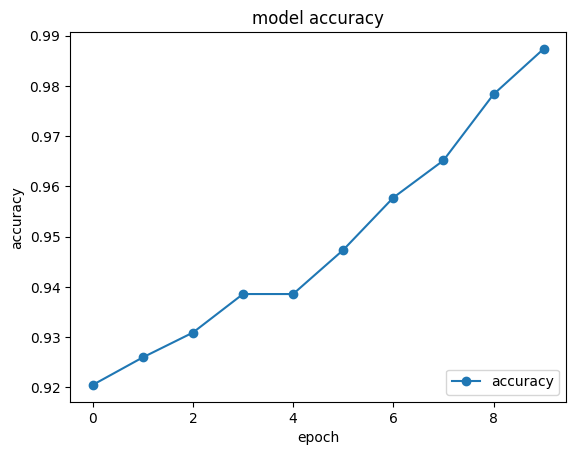

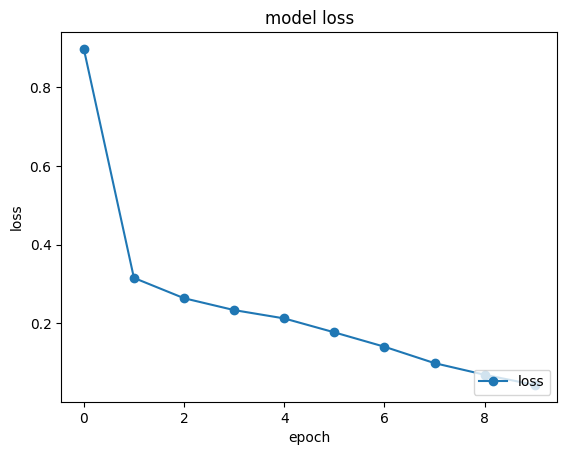

36/36 [==============================] - 1s 18ms/step
y_pred: [0 0 0 ... 0 0 0], (1140,)
y_test: [2. 1. 0. ... 0. 0. 0.], (1140,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 498, 64)           1216      
                                                                 
 conv1d_7 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 15872)             0         
                                                        

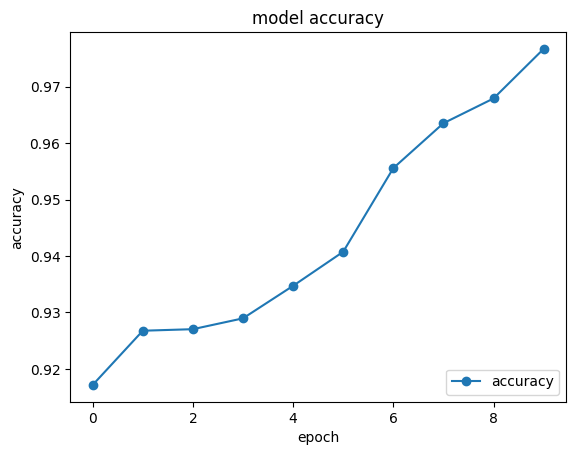

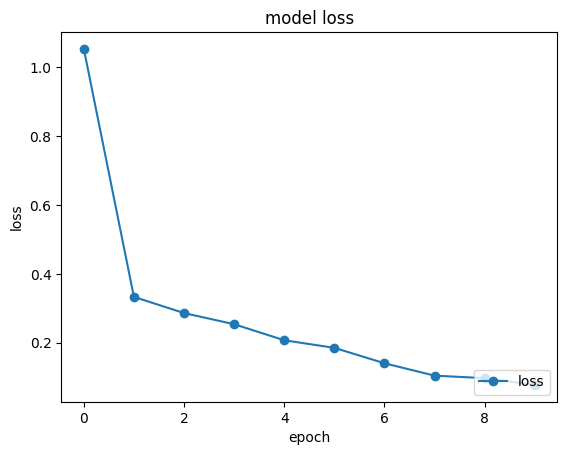

36/36 [==============================] - 1s 18ms/step
y_pred: [0 0 0 ... 0 0 0], (1140,)
y_test: [2. 2. 2. ... 0. 0. 0.], (1140,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 498, 64)           1216      
                                                                 
 conv1d_9 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 dropout_4 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 15872)             0         
                                                        

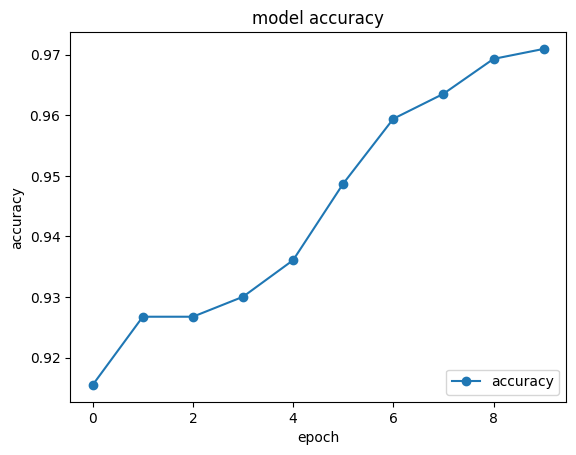

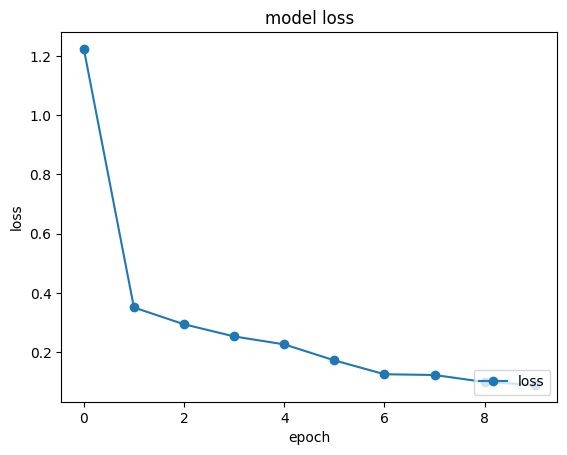

36/36 [==============================] - 1s 19ms/step
y_pred: [0 0 0 ... 0 0 0], (1140,)
y_test: [2. 1. 1. ... 0. 0. 0.], (1140,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 498, 64)           1216      
                                                                 
 conv1d_11 (Conv1D)          (None, 496, 64)           12352     
                                                                 
 dropout_5 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 15872)             0         
                                                        

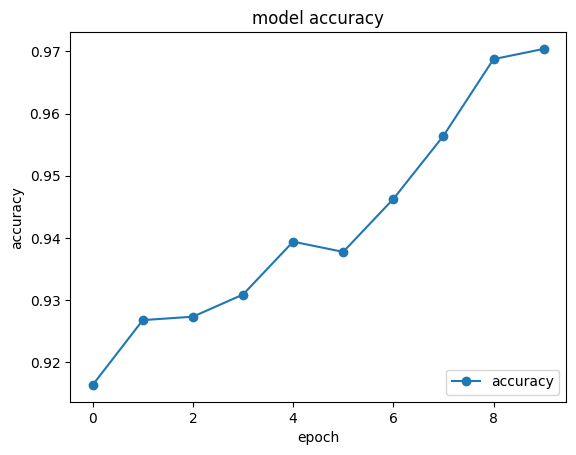

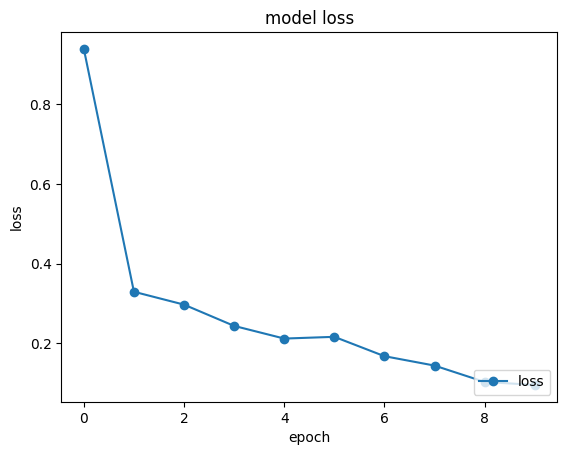

36/36 [==============================] - 1s 18ms/step
y_pred: [1 0 0 ... 0 0 0], (1139,)
y_test: [2. 1. 0. ... 0. 0. 0.], (1139,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 498, 64)           1216      
                                                                 
 conv1d_13 (Conv1D)          (None, 496, 64)           12352     
                                                                 
 dropout_6 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 15872)             0         
                                                        

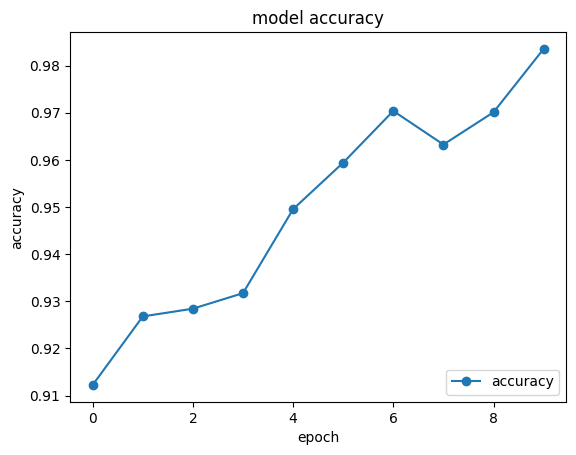

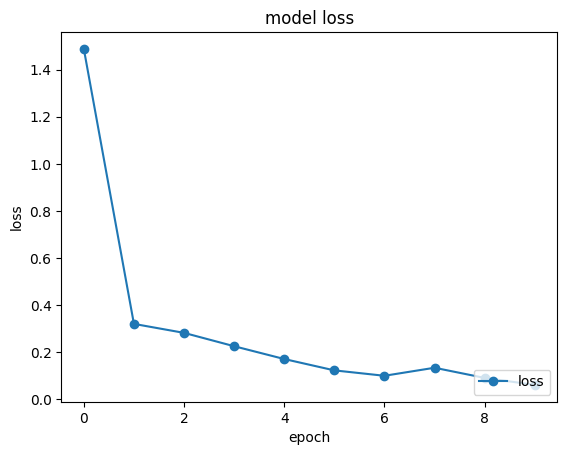

36/36 [==============================] - 1s 19ms/step
y_pred: [0 0 0 ... 0 0 0], (1139,)
y_test: [2. 2. 1. ... 0. 0. 0.], (1139,)
結果
0 回目:
accuracy  :  0.8991228070175439
macro_f1  :  0.31577325939617995

1 回目:
accuracy  :  0.9131578947368421
macro_f1  :  0.3186409550045914

2 回目:
accuracy  :  0.9114035087719298
macro_f1  :  0.34987899658558347

3 回目:
accuracy  :  0.913081650570676
macro_f1  :  0.360239852398524

4 回目:
accuracy  :  0.9113257243195786
macro_f1  :  0.3291117244199121

全体結果
accuracy ; 0.9096183170833141
macro_f1 ; 0.3347289575609582


<Figure size 640x480 with 0 Axes>

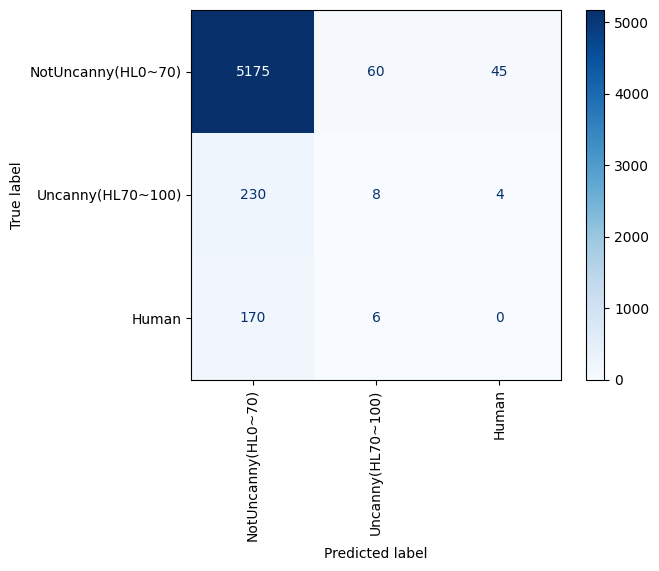

In [ ]:
# run an experiment
def main():
  score_dict ={'accuracy':[], 'macro_f1':[]}
  y_dict = {'y_true':[], 'y_pred':[]}
  date = "20231024_1"
  path = f"path/{date}/"
  i = 1

  #1 データの取得
  X, y, label = load_dataset('ML_dataset_20_ICA_baseline_6', 'labelD')
  kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
  for train_index, test_index in kf.split(X,y):
    #2 データの処理(k-hold　cross validationの実施)
    X_tr, X_val, y_tr, y_val, X_test, y_test = get_data(X, y, train_index, test_index)
    #3 モデルのトレーニング
    model = train_model(label, X_tr, y_tr, X_val, y_val, date, i, path)
    #4 モデルの評価
    y_dict, score_dict=evaluate_model(X_test, y_test, score_dict, y_dict, model)
    i = i + 1

  result(score_dict, y_dict, label, date, path)

  K.clear_session()

if __name__ == "__main__":
    main()